******** Exp.#1 ********
CleanData  10.139 s
build model  0.061 s
Smoothing  0.23317 s
task1 is  10.524 s
Recalls/Accuracy, Precision, F1 measure: 
 [[1.0, 0.98958, 0.99392], [0.75, 1.0, 0.87733], [0.88889, 1.0, 0.95018], [0.0, 0.0, 0.0], [0.99015, 0, 0]]
Confusion Matrix: 
 [[190, 0, 0, 0, 190], [1, 3, 0, 0, 4], [1, 0, 8, 0, 9], [0, 0, 0, 0, 0]]
task2 is  0.019 s
******** Exp.#2 ********
Recalls/Accuracy, Precision, F1 measure: 
 [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [1.0, 0, 0]]
Confusion Matrix: 
 [[190, 0, 0, 0, 190], [0, 4, 0, 0, 4], [0, 0, 9, 0, 9], [0, 0, 0, 0, 0]]
task3.1 is  0.642 s
******** Exp.#3 ********
Recalls/Accuracy, Precision, F1 measure: 
 [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [1.0, 0, 0]]
Confusion Matrix: 
 [[190, 0, 0, 0, 190], [0, 4, 0, 0, 4], [0, 0, 9, 0, 9], [0, 0, 0, 0, 0]]
task3.2 is  0.269 s
******** Exp.#4 ********
Recalls and Accuracy: 
 [[0.98421, 0.98947, 0.99474, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

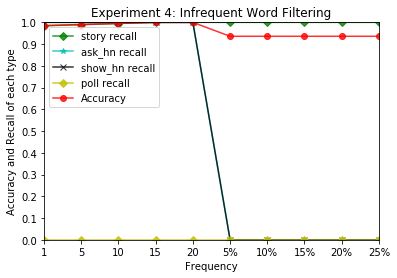

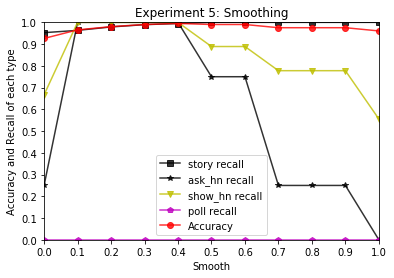

task3.4 is  4.00501 s
Total time is  16.95571 s


In [2]:
# -------------------------------------------------------
# Project2
# Written by Yilin Li(40083064), Yuhua Jiang(40083453)
# For COMP 6721 Section (lab FJ,FI) ? Fall 2019
# --------------------------------------------------------
import numpy as np
import pandas as pd
import math
import time
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import copy
import matplotlib.pyplot as plt
from random import choice
from decimal import *

# read the original CSV dataset
# extract goal columns
#Title
df = pd.read_csv("hn2018_2019.csv",usecols=[2],encoding = "ISO-8859-1")
col_Title=df.values.flatten()
#Post Type
df = pd.read_csv("hn2018_2019.csv",usecols=[3],encoding = "ISO-8859-1")
col_PostType = df.values.flatten()
#Create time
df = pd.read_csv("hn2018_2019.csv",usecols=[5],encoding = "ISO-8859-1")
col_CreatedAt = df.values.flatten()

# global variables
smooth = 0.00
typeList = {}   # store all the post-type
vocabulary = {}
testTitleSet = []
testTypeSet = []
sortedVocabulary = {}
score = []
removeList = []

titleWithoutStopWord = []
typeListTask3_1 = {}
vocabularyTask3_1 = {}
testTitleSetTask3_1 = []
testTypeSetTask3_1 = []
sortedVocabularyTask3_1 = {}
scoreTask3_1 = []

titleLimitLength = []
typeListTask3_2 = {}
vocabularyTask3_2 = {}
testTitleSetTask3_2 = []
testTypeSetTask3_2 = []
sortedVocabularyTask3_2 = {}
scoreTask3_2 = []

# useful data pattern
pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Za-z]\.)+
             |(?:[$#a-zA-Z]+)*[0-9]+(?:[-.,/0-9]+)*['a-zA-Z]+(?:[-.,/0-9]+)*(?:[a-zA-Z]+)*
             |[$#A-Za-z]+[0-9]+(?:[.,/0-9]+)*
             |[a-zA-Z]+(?:[-'_/&][a-zA-Z]+)*(?:[+])*
          """
# pattern=r'.*[a-zA-Z].*'
# give tag to each word
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

#clean the data set
#leave the english words, special numbers and phrase with underline
def cleanData():
    global col_Title
    global removeList
    for i in range(len(col_Title)):
        title = word_tokenize(col_Title[i])
        wordsAfterPattern=[]
        for j in title:
            if(len(j)<=17):
                temp = nltk.regexp_tokenize(j, pattern)
                if(len(temp)!=0):
                    wordsAfterPattern.append(temp[0])
        word = lemmatization(wordsAfterPattern)
        remove = list(set(title).difference(set(wordsAfterPattern)))
        for j in range(len(remove)):
            if(remove[j].lower() not in removeList):
                removeList.append(remove[j].lower())
        col_Title[i] = properNouns(word)
        # print(i)

# combain two nouns together in a single token if one is behind another
def properNouns(properList):
    properNounsList = []
    tagged_sent = pos_tag(properList)
    flag=0
    for i in range(len(tagged_sent)):
        if(flag==0):
            if(tagged_sent[i][1]=='NNP' and (i+1)< len(tagged_sent)):
                if(tagged_sent[i+1][1] == 'NNP'):
                     properNounsList.append(str(tagged_sent[i][0]).lower()+" "+str(tagged_sent[i+1][0]).lower())
                     flag=1
                else:
                    properNounsList.append(str(tagged_sent[i][0]).lower())
            else:
                properNounsList.append(str(tagged_sent[i][0]).lower())
            # if (tagged_sent[i][1] == 'NN' and (i + 1) < len(tagged_sent)):
            #     if (tagged_sent[i + 1][1] == 'NN'):
            #         properNounsList.append(str(tagged_sent[i][0]).lower() + " " + str(tagged_sent[i + 1][0]).lower())
            #         flag = 1
            #     else:
            #         properNounsList.append(str(tagged_sent[i][0]).lower())
            # else:
            #     properNounsList.append(str(tagged_sent[i][0]).lower())
        else:
            flag=0
    return properNounsList

# write a file contains all the words have been removed
def writeRemove():
    file = open("remove_word.txt", "w+",encoding='utf-8')
    for i in range(len(removeList)):
        file.write(str(removeList[i]) + "\n")

# lemmatization with a parameter(String)
def lemmatization(token):
    tagged_sent = pos_tag(token)     # get the original tag
    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        add=wnl.lemmatize(tag[0], pos=wordnet_pos)
        if(len(add)<=1 or str(add).isdigit()):
            if (str(add).lower() not in removeList):
                removeList.append(str(add).lower())
        else:
            lemmas_sent.append(add) # return the tag
    return lemmas_sent

# build the training and testing models
# store the training data in the vocabulary{}, store testing data in the testTitleSet{}, sortedVocabulary{}
def buildModel(vocabularyModel,typeListModel,testTitleSetModel,testTypeSetModel,col_TitleModel):
    for i in range(len(col_CreatedAt)):
        # if the title is created at 2018
        # store the unreaded post-type in typeList(dic) and calculate the frequency for each type
        if("2018" in str(col_CreatedAt[i])):
            tempValue = [] # two items, total number of titles in the type + total number of words in the type
            if(str(col_PostType[i]) not in typeListModel):
                tempValue.append(1)
                tempValue.append(len(col_TitleModel[i]))
                typeListModel[str(col_PostType[i])] = tempValue
            else:
                typeListModel[str(col_PostType[i])][0] = typeListModel.get(str(col_PostType[i]))[0] + 1
                typeListModel[str(col_PostType[i])][1] = typeListModel.get(str(col_PostType[i]))[1] + len(col_TitleModel[i])
        # if the title is created at 2019
        # store the title and type in two dicts
        elif("2019" in str(col_CreatedAt[i])):
            testTitleSetModel.append(col_TitleModel[i])
            testTypeSetModel.append(col_PostType[i])
        else:
            continue
    for i in range(len(col_TitleModel)):
        if ("2018" in str(col_CreatedAt[i])):
            # store the token in Vocabulary{}
            for y in range(len(col_TitleModel[i])):
                if (col_TitleModel[i][y] not in vocabularyModel.keys()):
                    # initial a list with two numpy array. The first one stores frequency; the second one stores probability
                    # vocabulary{} : key is the token name, value is two numpy arrays which store the frequency and probability
                    vocabularyModel[col_TitleModel[i][y]] = [np.zeros((len(typeListModel)), dtype=int), np.zeros((len(typeListModel)), dtype=float)]
                keys = list(typeListModel.keys())
                for k, v in typeListModel.items():
                    if (col_PostType[i] == k):
                        vocabularyModel[col_TitleModel[i][y]][0][keys.index(k)] = vocabularyModel[col_TitleModel[i][y]][0][keys.index(k)] + 1   # frequency

#smoothing and calculate the probability
def smoothing(vocabularyModel,smooth,typeListModel):
    for k, v in vocabularyModel.items():
        for i in range(len(v[1])):
            values = list(typeListModel.values())
            # v[1][i] = math.floor((math.log((v[0][i]+smooth)/(values[i][1]+(len(vocabularyModel)*smooth)),10))*10000000000)/10000000000
            v[1][i] = math.log((v[0][i] + smooth) / (values[i][1] + (len(vocabularyModel) * smooth)),10)
            v[1][i] = float(Decimal(v[1][i]).quantize(Decimal('.0000000001'), rounding=ROUND_DOWN))

# sort the vocabulary by alphapet order
def sortV(vocabularyModel):
    sortedVocabularyModel = dict(sorted(vocabularyModel.items(), key=lambda x: x[0].lower()))
    return sortedVocabularyModel

# write the file for wordModel
def writeFileTask1(sortedVocabularyModel,fileName,typeListModel):
    file = open(fileName, "w+",encoding="utf-8")     # all the words with frequency and probability
    count = 1
    for k, v in sortedVocabularyModel.items():
        string = str(count) + "  " + k + "  "
        for i in range(len(typeListModel)):
            if (i != len(typeListModel) - 1):
                string = string + str(v[0][i]) + "  " + str(v[1][i]) + "  "
            else:
                string = string + str(v[0][i]) + "  " + str(v[1][i]) + "\n"
        count = count + 1
        file.write(string)

def writeVocabulary():
    fileWord = open("vocabulary.txt", "w+",encoding='utf-8')  # all the words
    for k, v in sortedVocabulary.items():
        fileWord.write(str(k) + "\n")

# analyse the post-type of the testing set using naiveBays
def naiveBays(vocabularyModel,testTitleSetModel,testTypeSetModel,typeListModel,col_TitleModel,scoreModel):
    trainingData=0
    for k,v in typeListModel.items():
        trainingData=trainingData+v[0]
    for i in range(len(testTitleSetModel)):
        max = -1000000000000000000000.0
        match = ""
        sum = 0.0
        counterType = 0
        scoreTitle = []
        scoreTitle.append(i + 1)
        scoreTitle.append(testTitleSetModel[i])
        scoreTitle.append(testTypeSetModel[i])
        for k, v in typeListModel.items():
            sum=0.0
            sum = sum + math.log((v[0]/trainingData),10)  # calculate the log type
            for j in range(len(testTitleSetModel[i])):
                if(testTitleSetModel[i][j] in vocabularyModel):
                    sum = sum + (vocabularyModel.get(testTitleSetModel[i][j])[1][counterType])     # calculate the rest of the score
            counterType = counterType + 1
            sum=float(Decimal(sum).quantize(Decimal('.0000000001'), rounding=ROUND_DOWN))
            scoreTitle.append(sum)
            if(sum > max):      # get the highest score and the match post_type
                max = sum
                match = k
        scoreTitle.append(testTypeSetModel[i])
        scoreTitle[2] = match
        if(match == testTypeSetModel[i]):
            scoreTitle.append("right")
        else:
            scoreTitle.append("wrong")
        scoreModel.append(scoreTitle)

# writing result file for task2
def writeFileTask2(scoreModel,fileName):
    file = open(fileName, "w+",encoding='utf-8')
    for i in range(len(scoreModel)):
        string = ""
        for j in range(len(scoreModel[i])):
            stringTitle = ""
            if(j == 1):
                for n in range(len(scoreModel[i][j])):
                    if(n != len(scoreModel[i][j]) - 1):
                        stringTitle = stringTitle + str(scoreModel[i][j][n])+" "
                    else:
                        stringTitle = stringTitle + str(scoreModel[i][j][n])
                scoreModel[i][j] = stringTitle
            if(j != (len(scoreModel[i])-1)):
                string = string + str(scoreModel[i][j])+"  "
            else:
                string = string + str(scoreModel[i][j])+"\n"
        file.write(string)

def removeStopWord():
    global titleWithoutStopWord
    titleWithoutStopWord=copy.deepcopy(col_Title)
    stopWord = open("Stopwords.txt").read()
    stopWords = stopWord.split("\n")
    for i in range(len(titleWithoutStopWord)):
        titleWithoutStopWordTemp = []
        for o in range(len(titleWithoutStopWord[i])):
            flag = True
            for j in range(len(stopWords)):
                if(stopWords[j] == titleWithoutStopWord[i][o]):
                    flag=False
            if(flag):
                titleWithoutStopWordTemp.append(titleWithoutStopWord[i][o])
        titleWithoutStopWord[i]=titleWithoutStopWordTemp

def removeLength():
    global titleLimitLength
    titleLimitLength = copy.deepcopy(col_Title)
    for i in range(len(col_Title)):
        titleLimitLength[i]=[]
        for j in range(len(col_Title[i])):
            if(len(col_Title[i][j]) > 2 and len(col_Title[i][j]) < 9 ):
                titleLimitLength[i].append(col_Title[i][j])

def resultAnalysis(scoreModel,typeListModel,testTitleSetModel):
    resultAnylyse = [[0 for x in range(3)] for y in range(len(typeListModel) + 1)]  # Recalls/Accuracy, Precision, F1 measure
    confusionMatrix = [[0 for x in range(len(typeListModel)+1)] for y in range(len(typeListModel))]
    belta = 0.85
    A = np.zeros((len(typeListModel)), dtype=int)   # instances that are in this class  and that the model identified as this class
    B = np.zeros((len(typeListModel)), dtype=int)   # instances that are not in this class  but that the model identified as this class
    totalTitleinType = np.zeros((len(typeListModel)), dtype=int)
    sumCorrect = 0
    for i in range(len(scoreModel)):
        totalTitleinType[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])]=totalTitleinType[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])]+1
        if(scoreModel[i][len(scoreModel[i])-1]=='right'):
            A[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])] = A[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])]+1
            sumCorrect = sumCorrect +1
            confusionMatrix[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])][list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])]=confusionMatrix[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])][list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])]+1
        else:
            confusionMatrix[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])][list(typeListModel.keys()).index(scoreModel[i][2])]= confusionMatrix[list(typeListModel.keys()).index(scoreModel[i][len(scoreModel[i]) - 2])][list(typeListModel.keys()).index(scoreModel[i][2])]+1
            B[list(typeListModel.keys()).index(scoreModel[i][2])] = B[list(typeListModel.keys()).index(scoreModel[i][2])]+1
    for j in range(len(typeListModel)):
        confusionMatrix[j][len(typeListModel)]= totalTitleinType[j]     # total number of titles in this type
        if(totalTitleinType[j]==0):
            resultAnylyse[j][0]= 0.0
        else:
            resultAnylyse[j][0] = round(float(A[j])/float(totalTitleinType[j]),5)   # recall
        if((A[j]+B[j])==0):
            resultAnylyse[j][1] = 0.0
        else:
            resultAnylyse[j][1] = round(float(A[j])/round(float(A[j]+B[j]),5),5)    # precision
        if(resultAnylyse[j][0] ==0 and resultAnylyse[j][1]==0):
            resultAnylyse[j][2] = 0.0
        else:
            resultAnylyse[j][2] = round(round((belta*belta+1)*float(resultAnylyse[j][0])*float(resultAnylyse[j][1]),5)/round(belta*belta*float(resultAnylyse[j][1])+float(resultAnylyse[j][0]),5),5)    # F1 measure
    if(len(testTitleSetModel)!=0):
        resultAnylyse[len(typeList)][0]= round(float(sumCorrect)/float(len(testTitleSetModel)),5)   # accuracy
    print("Recalls/Accuracy, Precision, F1 measure: \n",resultAnylyse)
    print("Confusion Matrix: \n",confusionMatrix)


def task1():
    global sortedVocabulary
    print("******** Exp.#1 ********")
    timeCleanB = time.time()
    cleanData()
    timeCleanE = time.time()
    timeClean = round(timeCleanE - timeCleanB, 3)
    print('CleanData ',timeClean,"s")

    timeBuildB = time.time()
    buildModel(vocabulary,typeList,testTitleSet,testTypeSet,col_Title)
    timeBuidE = time.time()
    timeBuid = round(timeBuidE - timeBuildB, 3)
    print('build model ',timeBuid,"s")

    smooth = 0.5
    timeSmoothingB = time.time()
    smoothing(vocabulary,smooth,typeList)
    timeSmoothingE = time.time()
    timeSmoothing = round(timeSmoothingE-timeSmoothingB,5)
    print('Smoothing ',timeSmoothing,"s")

    sortedVocabulary = sortV(vocabulary)
    writeFileTask1(sortedVocabulary,"model-2018.txt",typeList)
    writeVocabulary()
    writeRemove()

def task2():
    naiveBays(vocabulary,testTitleSet,testTypeSet,typeList,col_Title,score)
    writeFileTask2(score,"baseline-result.txt")
    resultAnalysis(score,typeList,testTitleSet)

def task3_1():
    print("******** Exp.#2 ********")
    removeStopWord()
    buildModel(vocabularyTask3_1,typeListTask3_1,testTitleSetTask3_1,testTypeSetTask3_1,titleWithoutStopWord)
    smooth = 0.5
    smoothing(vocabularyTask3_1, smooth, typeListTask3_1)
    sortedVocabularyTask3_1 = sortV(vocabularyTask3_1)
    writeFileTask1(sortedVocabularyTask3_1, "stopword-model.txt", typeListTask3_1)
    naiveBays(vocabularyTask3_1, testTitleSetTask3_1, testTypeSetTask3_1, typeListTask3_1, titleWithoutStopWord, scoreTask3_1)
    writeFileTask2(scoreTask3_1, "stopword-result.txt")
    resultAnalysis(scoreTask3_1, typeListTask3_1, testTitleSetTask3_1)

def task3_2():
    print("******** Exp.#3 ********")
    removeLength()
    buildModel(vocabularyTask3_2, typeListTask3_2, testTitleSetTask3_2, testTypeSetTask3_2, titleLimitLength)
    smooth = 0.5
    smoothing(vocabularyTask3_2, smooth, typeListTask3_2)
    sortedVocabularyTask3_2 = sortV(vocabularyTask3_2)
    writeFileTask1(sortedVocabularyTask3_2, "wordlength-model.txt", typeListTask3_2)
    naiveBays(vocabularyTask3_2, testTitleSetTask3_2, testTypeSetTask3_2, typeListTask3_2, titleLimitLength,
              scoreTask3_2)
    writeFileTask2(scoreTask3_2, "wordlength-result.txt")
    resultAnalysis(scoreTask3_2, typeListTask3_2, testTitleSetTask3_2)

def task3_3():
    print("******** Exp.#4 ********")
    smooth = 0.5
    frequencyStep = 5
    initialFrequency = 1
    intialPercentage = 0.05
    listAfterRemove = []
    removeParameter = 1
    listSumType = []
    result = [[0 for x in range(10)] for y in range(len(typeList)+1)]

    vocabularyTotalFrequency = {}
    for k,v in vocabulary.items():
        sumFrequency = 0
        for q in range(len(v[0])):
            sumFrequency = sumFrequency+v[0][q]
        vocabularyTotalFrequency[k] = sumFrequency  # calculate total frequency
    sortTypeFrequency = dict(sorted(vocabularyTotalFrequency.items(), key=lambda d: d[1], reverse=True))    # sort by total frequency

    for i in range(0, 10):
        correctRateType = np.zeros((len(typeList)), dtype=float)
        correctNumType = np.zeros((len(typeList)), dtype=int)
        totalTitleinType = np.zeros((len(typeList)), dtype=int)
        counter = 0
        wordAfterRemove = {}
        vocabularyTask3_3 = {}
        col_TitleTask3_3 = copy.deepcopy(col_Title)
        typeListTask3_3 = {}
        testTitleSetTask3_3 = []
        testTypeSetTask3_3 = []
        scoreTask3_3=[]
        if(i< 5):   # frequency is numerical value
            if (i == 0):
                removeParameter = initialFrequency
            else:
                removeParameter = frequencyStep* i
        else:      # percentage frequency
            removeParameter = round((i-4)*intialPercentage,2)
        for k, v in sortTypeFrequency.items():
            if (removeParameter < 1):   # percentage frequency
                index = int(removeParameter * len(sortTypeFrequency))
                if (counter >= index):
                    wordAfterRemove[k] = v
                counter = counter + 1
            else:   # frequency is numerical value
                if (removeParameter == 1):
                    if (int(v) == 0 or int(v) > 1):
                        wordAfterRemove[k] = v
                elif (int(v) > removeParameter):
                    wordAfterRemove[k] = v

        keysWordAfterRemove=wordAfterRemove.keys()
        for w in range(len(col_Title)):
            for u in range(len(col_Title[w])):
                if(col_Title[w][u] not in keysWordAfterRemove):
                    col_TitleTask3_3[w].remove(col_Title[w][u])
        buildModel(vocabularyTask3_3, typeListTask3_3, testTitleSetTask3_3, testTypeSetTask3_3, col_TitleTask3_3)
        smoothing(vocabularyTask3_3,smooth,typeListTask3_3)
        naiveBays(vocabularyTask3_3, testTitleSetTask3_3, testTypeSetTask3_3, typeListTask3_3, col_TitleTask3_3, scoreTask3_3)

        sumForAllType = 0
        for u in range(len(scoreTask3_3)):
            totalTitleinType[list(typeListTask3_3.keys()).index(scoreTask3_3[u][len(scoreTask3_3[u])-2])] = totalTitleinType[list(typeListTask3_3.keys()).index(scoreTask3_3[u][len(scoreTask3_3[u])-2])] +1
            if (scoreTask3_3[u][len(scoreTask3_3[u]) - 1] == 'right'):
                correctNumType[list(typeListTask3_3.keys()).index(scoreTask3_3[u][len(scoreTask3_3[u])-2])]= correctNumType[list(typeListTask3_3.keys()).index(scoreTask3_3[u][len(scoreTask3_3[u])-2])]+1
                sumForAllType = sumForAllType + 1
        for x in range(len(typeListTask3_3)):
            if (totalTitleinType[x] == 0):
                correctRateType[x]=0.0
            else:
                correctRateType[x]= round(correctNumType[x]/totalTitleinType[x],5)  # Recall
                result[x][i] = correctRateType[x]
        result[len(typeListTask3_3)][i] = round(sumForAllType/len(testTitleSetTask3_3),5)   # accuracy
    print("Recalls and Accuracy: \n", result)

    plt.figure()
    scale_ls = range(10)
    index_ls = ['1', '5', '10', '15', '20', '5%', '10%', '15%', '20%', '25%']
    y_ticks = np.arange(0.0, 1.1, 0.1)
    plt.xlim(0,8)
    plt.ylim(0.0,1.0)
    plt.xticks(scale_ls, index_ls)
    plt.yticks(y_ticks)
    colorList = ["b", "g" , "c", "m", "y", "k"]
    pointList = ['cx-', 'mp-', 'r*-', 'rh-', 'ms-', 'r+-', 'rv-', 'mD-']
    for z in range(len(typeList)):
        line = plt.plot(index_ls, result[z], choice(pointList), color=choice(colorList), alpha=0.8, label=str(list(typeList.keys())[z])+" recall")  # type recall
    line = plt.plot(index_ls, result[len(typeListTask3_3)], 'ro-', color='r', alpha=0.8, label="Accuracy")     # accuracy
    plt.title('Experiment 4: Infrequent Word Filtering')
    plt.xlabel('Frequency')
    plt.ylabel('Accuracy and Recall of each type')
    plt.legend()
    # plt.show()

def task3_4():
    print("******** Exp.#5 ********")
    smooth = 0.0
    step = 0.1
    value = 0.000000000000001
    result = [[0 for x in range(11)] for y in range(len(typeList)+1)]
    for i in range(0, 11,1):
        typeListTask3_4 = {}
        testTitleSetTask3_4 = []
        testTypeSetTask3_4 = []
        vocabularyTask3_4 = {}
        scoreTask3_4 = []
        correctRateType = np.zeros((len(typeList)), dtype=float)
        correctNumType = np.zeros((len(typeList)), dtype=int)
        totalTitleinType = np.zeros((len(typeList)), dtype=int)
        correctNum = 0
        buildModel(vocabularyTask3_4, typeListTask3_4, testTitleSetTask3_4, testTypeSetTask3_4, col_Title)
        if(smooth==0.0):
            smooth=smooth+value
        smoothing(vocabularyTask3_4, smooth, typeListTask3_4)
        if(i==0):
            smooth= round(smooth - value,2)
        naiveBays(vocabularyTask3_4, testTitleSetTask3_4, testTypeSetTask3_4, typeListTask3_4, col_Title, scoreTask3_4)

        keys = list(typeListTask3_4.keys())
        for j in range(len(scoreTask3_4)):
            totalTitleinType[keys.index(scoreTask3_4[j][len(scoreTask3_4[j]) - 2])]=totalTitleinType[keys.index(scoreTask3_4[j][len(scoreTask3_4[j]) - 2])]+1
            if (scoreTask3_4[j][len(scoreTask3_4[j]) - 1] == 'right'):
                correctNum = correctNum + 1
                correctNumType[keys.index(scoreTask3_4[j][len(scoreTask3_4[j]) - 2])]= correctNumType[keys.index(scoreTask3_4[j][len(scoreTask3_4[j]) - 2])]+1
        for x in range(len(correctNumType)):
            if(totalTitleinType[x]==0):
                correctRateType[x]=0.0
            else:
                correctRateType[x]= round(correctNumType[x]/totalTitleinType[x],5)   # recall
            result[x][i] = correctRateType[x]
        result[len(typeList)][i] =round(correctNum/len(scoreTask3_4),5)     # accuracy
        smooth = round(smooth + step, 1)
    print("Recalls and Accuracy: \n", result)

    plt.figure()
    x = np.arange(0.0,1.1,0.1)
    y = np.arange(0.0, 1.1, 0.1)
    plt.xticks(x)
    plt.yticks(y)
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    colorList=["b","g","c","m","y","k"]
    pointList = ['cx-', 'mp-', 'r*-', 'r+-', 'rv-', 'mD-', 'rh-', 'ms-']
    for z in range(len(typeList)):
        line = plt.plot(x, result[z], choice(pointList), color=choice(colorList),alpha=0.8, label=str(list(typeList.keys())[z])+" recall")  # type recall
    line = plt.plot(x, result[len(typeList)], 'ro-', color='r', alpha=0.8, label="Accuracy")   # accuracy
    plt.title('Experiment 5: Smoothing')
    plt.xlabel('Smooth')
    plt.ylabel('Accuracy and Recall of each type')
    plt.legend()
    plt.show()

# task 1 and 2
time_start11 = time.time()
task1()
time_end11 = time.time()
time11 = round(time_end11 - time_start11,3)
print("task1 is ",time11,"s")
time_start12 = time.time()
task2()
time_end12 = time.time()
time12 = round(time_end12-time_start12,3)
print("task2 is ",time12,"s")
# task 3.1
time_start2 = time.time()
task3_1()
time_end2 = time.time()
time2 = round(time_end2-time_start2,3)
print("task3.1 is ",time2,"s")
#task 3.2
time_start3 = time.time()
task3_2()
time_end3 = time.time()
time3 = round(time_end3-time_start3,3)
print("task3.2 is ",time3,"s")
#task 3.3
time_start4 = time.time()
task3_3()
time_end4 = time.time()
time4 = round(time_end4-time_start4,3)
print("task3.3 is ",time4,"s")
#task 3.4
time_start5 = time.time()
task3_4()
time_end5 = time.time()
time5 = round(time_end5-time_start5,5)
print("task3.4 is ",time5,"s")

timeTotal=round(time_end5-time_start11,5)
print("Total time is ",timeTotal,"s")

# print(typeList)